# 882 Replication with SOEP Data

- SOEP from CPS, 2017
- Estimation strategy from Flabbi 2010 

- Need to add education and race for homogeneity in types

## Import Packages

In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd

# General
import pdb

# Estimation
from scipy.optimize import minimize
import scipy.stats as stats
# import numdifftools as ndt

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn.apionly as sns
from pylab import *

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Import Data 

- SOEP (Germany) data on gender, wages, duration of unemployment
- M: males
- F: females
- U: unemployed
- E: employed 
- {M,F} X {E,U} = {males,females} X {employed, unemployed}

In [2]:
df=pd.read_stata('../data/merged.dta') # 624,562
df.columns = ['pid', 'year', 'inc_gro', 'inc_net', 'pos', 'emplsta', 'change', 'change_reason', 'dur', 'sex', 'age']

# Only the year 2017
df1 = df[df['year']==2017] # 31,630

# Turning categorical into dummies
df_sex = pd.get_dummies(df1, columns=['sex'])
df_empl = pd.get_dummies(df_sex, columns=['emplsta'])
# 1 if man, 2 if woman. 
# 5 if unemployed, 1 if full time

# Keeping only the necessary variables 
df2 = df_empl[['inc_net', 'dur', 'age', 'sex_[2] weiblich', 'emplsta_[1] Voll erwerbstaetig', 'emplsta_[5] Nicht erwerbstaetig']]
df2.columns = ['wage', 'dur', 'age', 'women', 'ft_empl', 'unempl']

# Using age for condition, then dropping age as a variable
AGE_LOW = (df2['age']>29)
AGE_HIGH = (df2['age']<56)
AGE_COND = AGE_LOW & AGE_HIGH

df3 = df2[AGE_COND==True] # 15,443

# Creating condition for FT employment or unemployed only 
FT_COND = (df3['ft_empl']==1)
UN_COND = (df3['unempl']==1)
EMPL_COND = FT_COND | UN_COND

df4 = df3[EMPL_COND==True] # 11,533
df4.columns = ['wage', 'dur', 'age', 'women', 'empl', 'unempl']

# Remove (-2) for "missing value" in wage for unemployed
df4.loc[df4['wage']==-2, 'wage']=0

# Dropping unnecessary columns (age and unempl) and reorganizing to be consistent with CPS organization
df5 = df4[['dur', 'wage', 'empl', 'women']]

# Removing negative values for duration
POS_DUR_COND = (df5['dur']>=0)

df6 = df5[POS_DUR_COND==True] # 11,399

# Ensure not unemployment spell for employed
UNEMPL_COND = (df6['empl']==0)
ZERO_DUR_COND = (df6['dur']==0)
EMPL_COND2 = (df6['empl']==1)
CONSIST_COND = (EMPL_COND2 & ZERO_DUR_COND) | UNEMPL_COND

df7 = df6[CONSIST_COND==True] #8,881

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
# Change wage to be hourly 

df7['wage'] = df7['wage'] / (40*4)

df7.describe()

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,dur,wage,empl,women
count,8881.000000,8881.000000,8881.000000,8881.000000
mean,1.089369,8.361424,0.501295,0.447810
std,3.177664,10.918726,0.500026,0.497297
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.500000,14.381250,1.000000,1.000000
max,33.000000,228.750000,1.000000,1.000000


In [5]:
# Creating naming conventions that are consistent with analysis from CPS data

data = df7

M = data[data['women']==0] # men 
F = data[data['women']==1] # women 
U = data[data['empl']==0] # unemployed
E = data[data['empl']==1] # employed

ME = M[M['empl']==1] # employed men
MU = M[M['empl']==0] # unemployed men
FE = F[F['empl']==1] # employed women
FU = F[F['empl']==0] # unemployed women

### Summary Statistics, without trimming

In [6]:
agg_dict = {
    'wage': ['mean', 'std', 'count'],
    'dur': ['mean', 'std', 'count'],
}

In [7]:
print(data.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrrrr}
\toprule
  &   & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
  &   &       mean &        std & count &      mean &       std & count \\
women & empl &            &            &       &           &           &       \\
\midrule
0 & 0 &   0.000000 &   0.000000 &  1825 &  2.419452 &  4.114749 &  1825 \\
  & 1 &  18.019649 &  10.816060 &  3079 &  0.000000 &  0.000000 &  3079 \\
1 & 0 &   0.000000 &   0.000000 &  2604 &  2.019662 &  4.294903 &  2604 \\
  & 1 &  13.674659 &   6.773855 &  1373 &  0.000000 &  0.000000 &  1373 \\
\bottomrule
\end{tabular}



In [8]:
print(data.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
{} &       mean &       std & count &      mean &       std & count \\
empl &            &           &       &           &           &       \\
\midrule
0    &   0.000000 &  0.000000 &  4429 &  2.184398 &  4.225716 &  4429 \\
1    &  16.679651 &  9.953472 &  4452 &  0.000000 &  0.000000 &  4452 \\
\bottomrule
\end{tabular}



### Summary Statistics, with trimming

In [9]:
print(np.percentile(ME['wage'], 5))

7.786249999999999


In [10]:
print(np.percentile(ME['wage'],95))

35.0


In [11]:
print(np.percentile(FE['wage'], 5))

6.01125


In [12]:
print(np.percentile(FE['wage'],95))

26.21249999999999


In [ ]:
# # Only trim bottom 

# M_WAGE_COND = (data['wage'] > 1245) #hard coded percentile so it does not continually update
# M_COND = (data['women'] == 0)

# F_WAGE_COND = (data['wage'] > 961) #hard coded percentile so it does not continually update
# F_COND = (data['women'] == 1)

# DUR_COND = (data['dur'] > 0)

# trim = data[ (M_COND & M_WAGE_COND) | (F_COND & F_WAGE_COND) | DUR_COND ]

# M = trim[trim['women']==0] 
# F = trim[trim['women']==1] 
# U = trim[trim['empl']==0] 
# E = trim[trim['empl']==1] 

# ME = M[M['empl']==1] 
# MU = M[M['empl']==0] 
# FE = F[F['empl']==1] 
# FU = F[F['empl']==0] 

In [45]:
# Trim both ends

M_WAGE_COND_L = (data['wage'] > 7.786249999999999) #hard coded percentile so it does not continually update
M_WAGE_COND_H = (data['wage'] < 35)
M_COND = (data['women'] == 0)

F_WAGE_COND_L = (data['wage'] > 6.01125) #hard coded percentile so it does not continually update
F_WAGE_COND_H = (data['wage'] < 26.21249999999999)
F_COND = (data['women'] == 1)

DUR_COND = (data['dur'] > 0)

trim = data[ (M_COND & M_WAGE_COND_L & M_WAGE_COND_H) | (F_COND & F_WAGE_COND_L & M_WAGE_COND_H) | DUR_COND ] #6,519

M = trim[trim['women']==0] 
F = trim[trim['women']==1] 
U = trim[trim['empl']==0] 
E = trim[trim['empl']==1] 

ME = M[M['empl']==1] 
MU = M[M['empl']==0] 
FE = F[F['empl']==1] 
FU = F[F['empl']==0] 

In [46]:
print(trim.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrrrr}
\toprule
  &   & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
  &   &       mean &       std & count &      mean &       std & count \\
women & empl &            &           &       &           &           &       \\
\midrule
0 & 0 &   0.000000 &  0.000000 &  1300 &  3.396538 &  4.522471 &  1300 \\
  & 1 &  16.959963 &  6.094529 &  2769 &  0.000000 &  0.000000 &  2769 \\
1 & 0 &   0.000000 &  0.000000 &  1170 &  4.495043 &  5.471515 &  1170 \\
  & 1 &  13.678350 &  5.266233 &  1280 &  0.000000 &  0.000000 &  1280 \\
\bottomrule
\end{tabular}



In [47]:
print(trim.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{wage} & \multicolumn{3}{l}{dur} \\
{} &       mean &       std & count &      mean &       std & count \\
empl &            &           &       &           &           &       \\
\midrule
0    &   0.000000 &  0.000000 &  2470 &  3.916883 &  5.023561 &  2470 \\
1    &  15.922555 &  6.040666 &  4049 &  0.000000 &  0.000000 &  4049 \\
\bottomrule
\end{tabular}



## Figures 

- Distribution of wages, men and women

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


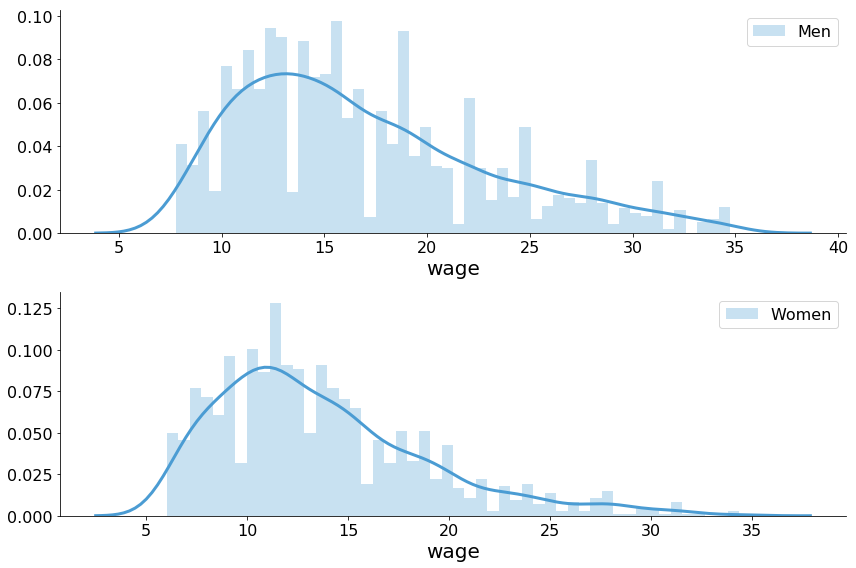

In [65]:
# Seaborn
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.distplot(ME['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[0])
sns.distplot(FE['wage'], color='#4B9CD3', hist_kws={'alpha' : .3}, bins=50, ax=ax[1])

ax[0].legend(['Men'])
ax[1].legend(['Women']) 

plt.tight_layout()

In [66]:
fig.savefig('./figures/fig1_2_SOEP.png', bbox_inches='tight', transparent=True)

## Estimation 

### Initial Conditions

In [48]:
λ = 0.25530507424781373
λ_M = 0.29441739346048834
λ_F = 0.22246729559007514

η = 0.15574303121563346
η_M = 0.13822412838520579
η_F = 0.20334901237530306

μ = 15.922555
μ_M = 16.959963
μ_F= 13.678350

σ = 6.040666
σ_M = 6.094529
σ_F = 5.266233

p = 0.5
d = 10

### Parameters without distributional assumptions

In [58]:
wstarM = min(ME['wage'])
wstarF = min(FE['wage'])

hM = MU['dur'].count()/sum(MU.values[:,0])
hF = FU['dur'].count()/sum(FU.values[:,0])
h = U['dur'].count()/sum(U.values[:,0])

ηM = hM * (MU['dur'].count()/ME['empl'].count())
ηF = hF * (FU['dur'].count()/FE['empl'].count())
η = h * (U['dur'].count()/E['empl'].count())

α = 0.5

In [62]:
hM

0.29441739346048834

### Accepted Wage Function and Distributions

In [50]:
def dens_accepted(wage: np.array, α: float, μ: float, σ: float, wstar: float):
    """
    Calculates the density of accepted wages using the lognormal distribution
    """
    
    l = (α*μ) + ((1-α)*wstar)
    s = α * σ
    shape = 1
    
    sf_in = (wstar - l)/s
    
    return stats.lognorm.pdf(wage, shape, l, s) / stats.lognorm.sf(sf_in, shape, l, s)

In [51]:
def dens_accepted_prej(wage: np.array, α: float, μ: float, σ: float, wstar: float, d: float):
    """
    Calculates the density of accepted wages when prejudice is present using the lognormal distribution
    """
    
    l = (α*μ) + ((1-α)*wstar) - α*d
    s = α * σ
    shape = 1
    
    sf_in = (wstar - l)/s
    
    return stats.lognorm.pdf(wage,shape,l,s) / stats.lognorm.sf(sf_in, shape, l, s)

In [52]:
def lambdaM(h: float, wstarM: float, α: float, μ: float, σ: float):
    """
    Estimates lambda for men
    """
    
    l = (α*μ) + ((1-α)*wstarM)
    s = α * σ
    shape = 1
    
    sf_in = (wstarM-l)/s
    
    denom = stats.lognorm.sf(sf_in, shape, l, s)
    
    return h/denom

In [31]:
lambdaM(hM, wstarM, α, μ_M, σ_M)

0.29441739346048834

In [36]:
lambdaM(h,wstarF,α,μ,σ)

0.25530507424781373

In [53]:
def lambdaF(h: float, wstarF: float, α: float, μ: float, σ: float, p: float):
    """
    Estimates lambda for women
    """
    
    l1 = (α*μ) + ((1-α)*wstarF)
    l2 = (α*μ) + ((1-α)*wstarF) - α*d
    s = α * σ
    shape = 1
    
    sf_in1 = (wstarF-l1)/s
    sf_in2 = (wstarF-l2)/s
    
    denom = (1-p)*stats.lognorm.sf(sf_in1, shape, l1, s) + p*stats.lognorm.sf(sf_in2, shape, l2, s)
    
    return h/denom

In [33]:
lambdaF(hF, wstarF, α, μ_F, σ_F, 0.5)

0.22246729559007514

### Test Statistics

In [54]:
def teststats (hess_inv : np.ndarray, lnL : float, nparams : int):
    """
    Calculates the standard errors and p value from the LR tests
    """
    se = np.sqrt(np.diag(hess_inv))
    
    loglik_H0 = lnL_6
    
    LR = 2 * (lnL - loglik_H0)
    pval = stats.chi2.pdf(LR, nparams)
    
    return print('standard errors: ', se ,'. p = ', pval)

### Likelihood Functions

#### Estimation 6

In [63]:
def loglik_6( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences 
    
    Estimation 6
    
    Parameters to estimate: 
        λM
        λF
        ηM
        ηF
        μM
        σM
        μF
        σF
        d
        p
    """
    
    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μM = params[4]
    σM = np.exp(params[5])
    μF = params[6]
    σF = np.exp(params[7])
    d = np.exp(params[8])
    p = np.exp(params[9])/(1+np.exp(params[9]))

#    pdb.set_trace()
    
    # Men's equations 
    λM = lambdaM(hM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    # Women's equations
    λF = lambdaF(hF, wstarF, α, μM, σM, p)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μF, σF, wstarF, d)

    i = np.sum( np.log( y + z ) )
    
    return (a + b + c + e + f + g + h + i)

In [56]:
# Check on log-likelihood

param6 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F, d, p]

b6_0 = np.log(param6[0])
b6_1 = np.log(param6[1])
b6_2 = np.log(param6[2])
b6_3 = np.log(param6[3])
b6_4 = param6[4]
b6_5 = np.log(param6[5])
b6_6 = param6[6]
b6_7 = np.log(param6[7])
b6_8 = np.log(param6[8])
b6_9 = np.log(1)

init6 = [b6_0, b6_1, b6_2, b6_3, b6_4, b6_5, b6_6, b6_7, b6_8, b6_9]

print(loglik_6(init6))

-inf


/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


In [57]:
print(init6)

[-1.2227568128247779, -1.5029751742913813, -1.9788787925461115, -1.5928315034132423, 16.959963, 1.807391483491144, 13.67835, 1.6613153062023895, 2.302585092994046, 0.0]


In [64]:
est_6 = minimize(loglik_6, init6)

est_6

> <ipython-input-63-63f8f900a0cd>(34)loglik_6()
-> λM = lambdaM(hM, wstarM, α, μM, σM)
> <ipython-input-63-63f8f900a0cd>(36)loglik_6()
-> a = M['dur'].count() * np.log(hM/(hM+ηM))
0.29441739346048834
> <ipython-input-63-63f8f900a0cd>(37)loglik_6()
-> b = MU['dur'].count() * np.log(ηM)
params = array([-1.22275681, -1.50297517, -1.97887879, -1.5928315 , 16.959963  ,
        1.80739148, 13.67835   ,  1.66131531,  2.30258509,  0.        ])
-1566.2029600362328
*** NameError: name 'b' is not defined
> <ipython-input-63-63f8f900a0cd>(38)loglik_6()
-> c = - hM * np.sum(MU.values[:,0])
-2572.542430309945
> <ipython-input-63-63f8f900a0cd>(39)loglik_6()
-> e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
-1300.0


/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log


> <ipython-input-63-63f8f900a0cd>(42)loglik_6()
-> λF = lambdaF(hF, wstarF, α, μM, σM, p)


BdbQuit: 

In [42]:
# Coefficients

λM_6 = np.exp(est_6.x[0])
λF_6 = np.exp(est_6.x[1])
ηM_6 = np.exp(est_6.x[2])
ηF_6 = np.exp(est_6.x[3])
μM_6 = est_6.x[4]
σM_6 = np.exp(est_6.x[5])
μF_6 = est_6.x[6]
σF_6 = np.exp(est_6.x[7])
d_6 = np.exp(est_6.x[8])
p_6 = np.exp(est_6.x[9])/(1+np.exp(est_6.x[9]))

print(λM_6, λF_6, ηM_6, ηF_6, μM_6, σM_6, μF_6, σF_6, d_6, p_6)

0.18000000000000002 0.28 0.13822412838520579 0.20334901237530303 16.959963 6.094528999999999 13.67835 5.266232999999999 10.000000000000002 0.5


In [43]:
lnL_6 = est_6.fun

print(lnL_6)

-inf


In [44]:
ts_6 = teststats(est_6.hess_inv, lnL_6, 10)

standard errors:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] . p =  nan


/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


#### Estimation 3

In [ ]:
def loglik_3( params: list ):
    """
    Calculates log likelihood with prejudice and productivity differences 
    
    Estimation 3 (η and h not gender specific)
    
    Parameters to estimate: 
        λ 
        η
        μM
        σM
        μF
        σF
        d
        p
    """
    
    λM = np.exp(params[0]) #same lambda
    λF = np.exp(params[0]) #same lambda
    η = np.exp(params[1]) #same eta
    μM = params[2]
    σM = np.exp(params[3])
    μF = params[4]
    σF = np.exp(params[5])
    d = np.exp(params[6])
    p = np.exp(params[7])/(1+np.exp(params[7]))
    
    # Men's equations
    λM = lambdaM(h, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(h/(h+η))
    b = MU['dur'].count() * np.log(η)
    c = - h * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    λF = lambdaF(h, wstarF, α, μM, σM, p)
    
    f = F['dur'].count() * np.log(h/(h+η))
    g = FU['dur'].count() * np.log(η)
    i = - h * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μF, σF, wstarF, d)

    j = np.sum( np.log( y + z ) )
    
    
    return a + b + c + e + f + g + i + j

In [ ]:
# Check on log-likelihood

param3 = [λ, η, μ_M, σ_M, μ_F, σ_F, d, p]

b3_0 = np.log(param3[0])
b3_1 = np.log(param3[1])
b3_2 = param3[2]
b3_3 = np.log(param3[3])
b3_4 = param3[4]
b3_5 = np.log(param3[5])
b3_6 = np.log(param3[6])
b3_7 = np.log(1)

init3 = [b3_0, b3_1, b3_2, b3_3, b3_4, b3_5, b3_6, b3_7]

print(loglik_3(init3))

In [ ]:
est_3 = minimize(loglik_3, init3)

est_3

In [ ]:
# Coefficients

λ_3 = np.exp(est_3.x[0])
η_3 = np.exp(est_3.x[1])
μM_3 = est_3.x[2]
σM_3 = np.exp(est_3.x[3])
μF_3 = est_3.x[4]
σF_3 = np.exp(est_3.x[5])
d_3 = np.exp(est_3.x[6])
p_3 = np.exp(est_3.x[7])/(1+np.exp(est_3.x[7]))

print(λ_3, η_3, μM_3, σM_3, μF_3, σF_3, d_3, p_3)

In [ ]:
lnL_3 = est_3.fun

print(lnL_3)

In [ ]:
ts_3 = teststats(est_3.hess_inv, lnL_3, 8)

#### Estimation 5

In [ ]:
def loglik_5( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences. 
    
    Estimation 5 (ηM, ηF, hM, hF)
    
    Parameters to estimate: 
        λM # see fxn elsewhere
        λF # see fxn elsewhere
        μ
        σ
        p
        d
    """

    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μ = params[4]
    σ = np.exp(params[5])
    d = np.exp(params[6])
    p = np.exp(params[7])/(1+np.exp(params[7]))
    
    # Men's equations 
    λM = lambdaM(hM, wstarM, α, μ, σ)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    λF = lambdaF(hF, wstarF, α, μ, σ, p)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    i = np.sum( np.log( y + z ) )
    
    
    return a + b + c + e + f + g + h + i

In [ ]:
# Check on log-likelihood

param5 = [λ_M, λ_F, η_M, η_F, μ, σ, d, p]

b5_0 = np.log(param6[0])
b5_1 = np.log(param6[1])
b5_2 = np.log(param6[2])
b5_3 = np.log(param6[3])
b5_4 = param6[4]
b5_5 = np.log(param6[5])
b5_6 = np.log(param6[6])
b5_7 = np.log(1)

init5 = [b5_0, b5_1, b5_2, b5_3, b5_4, b5_5, b5_6, b5_7]

print(loglik_5(init5))

In [ ]:
est_5 = minimize(loglik_5, init5)

est_5

In [ ]:
# Coefficients

λM_5 = np.exp(est_5.x[0])
λF_5 = np.exp(est_5.x[1])
ηM_5 = np.exp(est_5.x[2])
ηF_5 = np.exp(est_5.x[3])
μ_5 = est_5.x[4]
σ_5 = np.exp(est_5.x[5])
d_5 = np.exp(est_5.x[6])
p_5 = np.exp(est_5.x[7])/(1+np.exp(est_5.x[7]))

print(λM_5, λF_5, ηM_5, ηF_5, μ_5, σ_5, d_5, p_5)

In [ ]:
lnL_5 = est_5.fun

print(lnL_5)

In [ ]:
ts_5 = teststats(est_5.hess_inv, lnL_5, 8)

#### Estimation 2

In [ ]:
def loglik_2( params: list ):
    """
    Calculates log likelihood with prejudice, no productivity differences. 
    
    Estimation 2 (η and h not gender specific)
    
    Parameters to estimate: 
        λ # see fxn elsewhere
        μ
        σ
        p
        d
    """
    
    λM = np.exp(params[0])
    λF = np.exp(params[0])
    η = np.exp(params[1])
    μ = params[2]
    σ = np.exp(params[3])
    d = np.exp(params[4])
    p = np.exp(params[5])/(1+np.exp(params[5]))

    
    # Men's equations 
    λM = lambdaM(h, wstarM, α, μ, σ)
    
    a = M['dur'].count() * np.log(h/(h+η))
    b = MU['dur'].count() * np.log(η)
    c = - h * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μ, σ, wstarM) ) )
    
    
    # Women's equations
    λF = lambdaF(h, wstarF, α, μ, σ, p)
    
    f = F['dur'].count() * np.log(h/(h+η))
    g = FU['dur'].count() * np.log(η)
    i = - h * np.sum(FU.values[:,0])
    
    y = ((1-p)/α) * dens_accepted(FE['wage'], α, μ, σ, wstarF)
    z = (p/α) * dens_accepted_prej(FE['wage'], α, μ, σ, wstarF, d)

    j = np.sum( np.log( y + z ) )
    
    
    return a + b + c + e + f + g + i + j

In [ ]:
# Check on log-likelihood

param2 = [λ, η, μ, σ, d, p]

b2_0 = np.log(param2[0])
b2_1 = np.log(param2[1])
b2_2 = param2[2]
b2_3 = np.log(param2[3])
b2_4 = np.log(param2[4])
b2_5 = np.log(1)

init2 = [b2_0, b2_1, b2_2, b2_3, b2_4, b2_5]

print(loglik_2(init2))

In [ ]:
est_2 = minimize(loglik_2, init2)

est_2

In [ ]:
# Coefficients

λ_2 = np.exp(est_2.x[0])
η_2 = np.exp(est_2.x[1])
μ_2 = est_2.x[2]
σ_2 = np.exp(est_2.x[3])
d_2 = np.exp(est_2.x[4])
p_2 = np.exp(est_2.x[5])/(1+np.exp(est_2.x[5]))

print(λ_2, η_2, μ_2, σ_2, d_2, p_2)

In [ ]:
lnL_2 = est_2.fun

print(lnL_2)

In [ ]:
ts_2 = teststats(est_2.hess_inv, lnL_2, 6)

#### Estimation 4

In [ ]:
def loglik_4( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice
    
    Estimation 4 (ηM, ηF, hM, hF)
    
    Parameters to estimate: 
        λM # see fxn elsewhere
        λF # see fxn elsewhere
        μM
        σM
        μF
        σF
    """

    λM = np.exp(params[0])
    λF = np.exp(params[1])
    ηM = np.exp(params[2])
    ηF = np.exp(params[3])
    μM = params[4]
    σM = np.exp(params[5])
    μF = params[6]
    σF = np.exp(params[6])
    p = 0
    
    # Men's equations 
    λM = lambdaM(hM, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(hM/(hM+ηM))
    b = MU['dur'].count() * np.log(ηM)
    c = - hM * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    λF = lambdaF(hF, wstarF, α, μF, σF, p)
    
    f = F['dur'].count() * np.log(hF/(hF+ηF))
    g = FU['dur'].count() * np.log(ηF)
    h = - hF * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)

    i = np.sum( np.log( y ) )
    
    
    return a + b + c + e + f + g + h + i

In [ ]:
# Check on log-likelihood

param4 = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F]

b4_0 = np.log(param4[0])
b4_1 = np.log(param4[1])
b4_2 = np.log(param4[2])
b4_3 = np.log(param4[3])
b4_4 = param4[4]
b4_5 = np.log(param4[5])
b4_6 = param4[6]
b4_7 = np.log(param4[7])

init4 = [b4_0, b4_1, b4_2, b4_3, b4_4, b4_5, b4_6, b4_7]

print(loglik_4(init4))

In [ ]:
est_4 = minimize(loglik_4, init4)

est_4

In [ ]:
# Coefficients

λM_4 = np.exp(est_4.x[0])
λF_4 = np.exp(est_4.x[1])
ηM_4 = np.exp(est_4.x[2])
ηF_4 = np.exp(est_4.x[3])
μM_4 = est_4.x[4]
σM_4 = np.exp(est_4.x[5])
μF_4 = est_4.x[6]
σF_4 = np.exp(est_4.x[7])

print(λM_4, λF_4, ηM_4, ηF_4, μM_4, σM_4, μF_4, σF_4)

In [ ]:
lnL_4 = est_4.fun

print(lnL_4)

In [ ]:
ts_4 = teststats(est_4.hess_inv, lnL_4, 8)

#### Estimation 1

In [ ]:
def loglik_1( params: list ):
    """
    Calculates log likelihood with productivity differences, no prejudice
    
    Estimation 1 (η and h not gender specific)
    
    Parameters to estimate: 
        λ
        μM
        σM
        μF
        σF
    """

    λM = np.exp(params[0]) #same lambda
    λF = np.exp(params[0]) #same lambda
    η = np.exp(params[1]) #same eta
    μM = params[2]
    σM = np.exp(params[3])
    μF = params[4]
    σF = np.exp(params[5])
    p = 0
    
    # Men's equations 
    λM = lambdaM(h, wstarM, α, μM, σM)
    
    a = M['dur'].count() * np.log(h/(h+η))
    b = MU['dur'].count() * np.log(η)
    c = - h * np.sum(MU.values[:,0])
    e = np.sum( np.log( (1/α) * dens_accepted(ME['wage'], α, μM, σM, wstarM) ) )
    
    
    # Women's equations
    λF = lambdaF(h, wstarF, α, μF, σF, p)
    
    f = F['dur'].count() * np.log(h/(h+η))
    g = FU['dur'].count() * np.log(η)
    i = - h * np.sum(FU.values[:,0])
    
    y = (1/α) * dens_accepted(FE['wage'], α, μF, σF, wstarF)

    j = np.sum( np.log( y ) )
    
    
    return a + b + c + e + f + g + i + j

In [ ]:
# Check on log-likelihood

param1 = [λ, η, μ_M, σ_M, μ_F, σ_F]

b1_0 = np.log(param1[0])
b1_1 = np.log(param1[1])
b1_2 = param1[2]
b1_3 = np.log(param1[3])
b1_4 = param1[4]
b1_5 = np.log(param1[5])

init1 = [b1_0, b1_1, b1_2, b1_3, b1_4, b1_5]

print(loglik_1(init1))

In [ ]:
est_1 = minimize(loglik_1, init1)

est_1

In [ ]:
# Coefficients

λ_1 = np.exp(est_1.x[0])
η_1 = np.exp(est_1.x[1])
μM_1 = est_1.x[2]
σM_1 = np.exp(est_1.x[3])
μF_1 = est_1.x[4]
σF_1 = np.exp(est_1.x[5])

print(λ_1, η_1, μM_1, σM_1, μF_1, σF_1)

In [ ]:
lnL_1 = est_1.fun

print(lnL_1)

In [ ]:
ts_1 = teststats(est_1.hess_inv, lnL_1, 6)